<a href="https://colab.research.google.com/github/oganiler/google_colab/blob/main/Improved_VGG_style_CIFAR_10_By_Functional_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#Functional Keras API
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
#Load the data from cifar10
cifar10 = tf.keras.datasets.cifar10

#get the train and test numpy data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Type:", type(x_train))
print("Shape test_x:", x_test.shape)
print("Shape train_x:", x_train.shape)

#normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Shape train_y before flatten:", y_train.shape)
print("Shape test_y before flatten:", y_test.shape)

#unlike minist dataset, the target is 2D array
#so we should flatten it to make it like tensorflow expects
y_train = y_train.flatten()
y_test = y_test.flatten()

print("Shape train_y after flatten:", y_train.shape)
print("Shape test_y flatten:", y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 99s 1us/step
Type: <class 'numpy.ndarray'>
Shape test_x: (10000, 32, 32, 3)
Shape train_x: (50000, 32, 32, 3)
Shape train_y before flatten: (50000, 1)
Shape test_y before flatten: (10000, 1)
Shape train_y after flatten: (50000,)
Shape test_y flatten: (10000,)


In [4]:
#what is the number of unique values in y_train (number of classes)
K = len(set(y_train))
print( "number of classes:", K)

number of classes: 10


In [5]:
# data augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [6]:
# Build the model using the functional API
# each convulation layer the number of output is doubled
# we use stride=2 so that each layer the image size will be halved instead of using pooling
i = Input(shape = x_train[0].shape) #since the input shape is 3 color, the Conv2D will automatically create filters 3x3x3xN (wthout color: 1x3x3xN)

# data augmentation (only for training)
# Augmentation is part of the model graph, runs on GPU automatically, and is automatically disabled during inference/validation — which is exactly what we want.
x = data_augmentation(i)

# convolution layers with batch normalization after every convolution layer
# and max pooling for the downsample the data (instead of stride = 2 this time)
#we could have applied global max pooling, but not this time
x = Conv2D(32, (3,3), activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation = 'relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

# convolution layers drop out
#x = SpatialDropout2D(0.2)(x)  # Designed for CNN feature maps ← drops whole feature channels, much more effective

# flatten the convolution output
x = Flatten()(x) #convert the image into feature vector before the dense layer

#x = Dropout(0.2)(x) # Because adjacent values are correlated, dropping one scalar still leaves its neighbors to carry almost the same information — so the regularization effect is weaker than you'd expect.

# dense layer
x = Dense(1024, activation = 'relu')(x)

# dense layer drop out
x = Dropout(0.2)(x)

#output layer
x = Dense(K, activation = 'softmax')(x)

model = Model(i, x) # arguments of the model constructor: (list of inputs, list of outputs)

In [7]:
# !!! DO NOT RUN !!!
# Old way to run augmented data
#ImageDataGenerator + fit_generator (deprecated)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# *** Augmentation happens outside the model, on CPU, before data is fed in.
# Auto-disabled at validation should be handled manually, Deprecated since TF 2.1

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
steps_per_epoch = len(x_train) # with batch_size=32, the correct value is 50000 // 32 = 1562 for CIFAR-10

r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15)

AttributeError: 'Functional' object has no attribute 'fit_generator'

In [8]:
#Compile and fit
#Note: make sure using the GPU for this !

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Augmentation is part of the model graph, runs on GPU automatically, and is automatically disabled during inference/validation — which is exactly what we want.
#fit with data augmentation
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)


Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 557s 352ms/step - accuracy: 0.4006 - loss: 1.8553 - val_accuracy: 0.5345 - val_loss: 1.3322
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 535s 335ms/step - accuracy: 0.5717 - loss: 1.2155 - val_accuracy: 0.6323 - val_loss: 1.0772
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 524s 335ms/step - accuracy: 0.6403 - loss: 1.0315 - val_accuracy: 0.6593 - val_loss: 1.0011
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 531s 339ms/step - accuracy: 0.6836 - loss: 0.9107 - val_accuracy: 0.6691 - val_loss: 1.0081
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 582s 352ms/step - accuracy: 0.7118 - loss: 0.8371 - val_accuracy: 0.7324 - val_loss: 0.8079
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 569s 357ms/step - accuracy: 0.7335 - loss: 0.7805 - val_accuracy: 0.7418 - val_loss: 0.7820
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 547s 350ms/step - accuracy: 0.7487 - loss: 0.7338 - val_accuracy: 0.7715 - val_loss: 0.6741
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 560s 349ms/step - ac

In [9]:
# show that the data augmentation isn't applied during the inference
# as long as it is not random with data augmentation, the result should be same when we run twice
model.eveulate(x_test, y_test)

AttributeError: 'Functional' object has no attribute 'eveulate'

In [10]:
# show that the data augmentation isn't applied during the inference
# as long as it is not random with data augmentation, the result should be same when we run twice
model.eveulate(x_test, y_test)

AttributeError: 'Functional' object has no attribute 'eveulate'

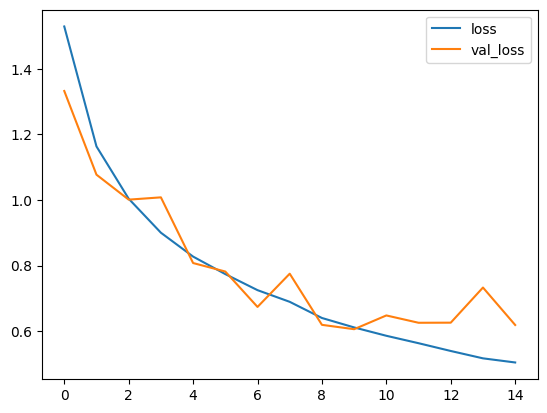

In [11]:
#plot the loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

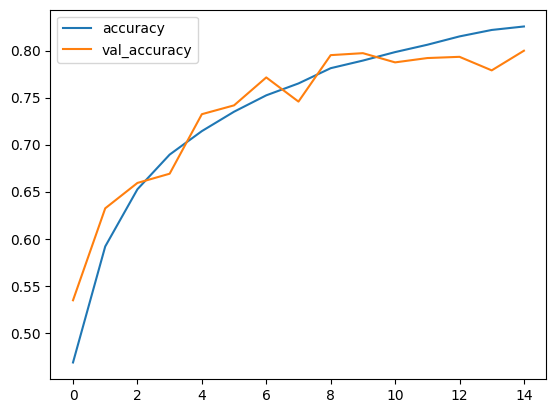

In [12]:
#plot the accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
Confusion matrix, without normalization
[[872  12  25  12   8   0   3   7  42  19]
 [ 12 921   0   0   0   0   7   2  14  44]
 [ 60   8 703  18  36  30 109  16  10  10]
 [ 30  19  41 577  44 100 103  25  29  32]
 [ 18   3  43  21 757   7 117  25   4   5]
 [ 11   7  33  79  38 705  68  28   8  23]
 [  3   4  17  14   9   6 933   2   8   4]
 [ 24   5  13  15  59  22  25 808   6  23]
 [ 84  10   8   0   4   1   5   1 876  11]
 [ 36  65   3   3   3   1  18   1  23 847]]


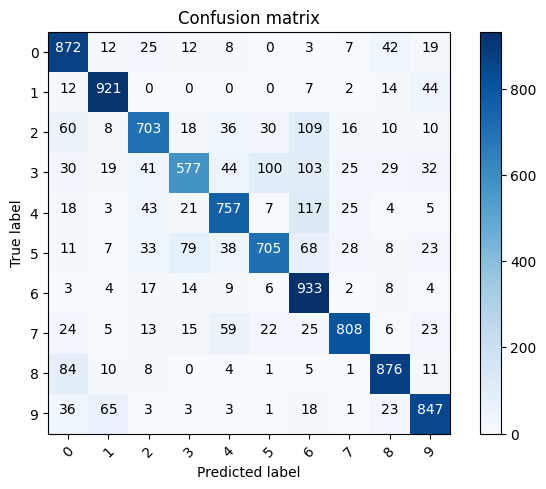

In [13]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

['airplane\nautomobile', '\nbird', '\ncat', '\ndeer', '\ndog\nfrog', '\nhorse', '\nship', '\ntruck']
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step


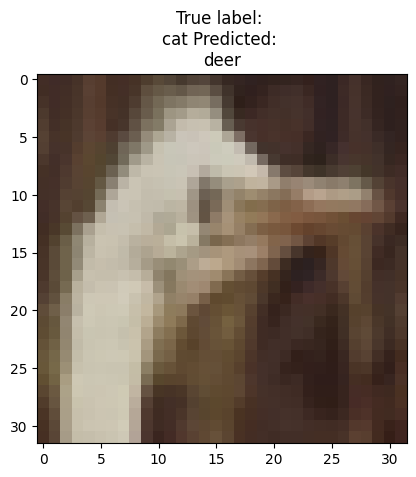

In [14]:
#show some misclassified examples
labels = '''airplane
automobile,
bird,
cat,
deer,
dog
frog,
horse,
ship,
truck'''.split(',')

print(labels)

p_test = np.argmax(model.predict(x_test), axis=1)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [15]:
# now that the model is so large, it is useful to summarize it
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,189,888 (27.43 MB)

 Trainable params: 2,396,330 (9.14 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 4,792,662 (18.28 MB)

In [ ]:
#instead of using numpy arrays, we could also use tensorflow datasets

#Create Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=10_000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit with TF Data
r = model.fit(train_dataset, epochs=15, validation_data=test_dataset)